In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
from sklearn import svm
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, accuracy_score, confusion_matrix, f1_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import plot_roc_curve, roc_curve, auc, precision_recall_curve
from sklearn.pipeline import Pipeline

First let's read the CSV and do quick EDA:

In [10]:
data = pd.read_csv('diab_ckd_data.csv')

Which colomns do we have?

In [11]:
data.columns

Index(['IDS', 'TIME_CRF', 'EVENT_CRF', 'IS_MALE', 'AGE_AT_SDATE', 'AGE_GROUP',
       'SES_GROUP', 'MIGZAR', 'IS_HYPERTENSION', 'SE_HYPERTENSION',
       'IS_ISCHEMIC_MI', 'SE_ISCHEMIC_MI', 'IS_CVA_TIA', 'SE_CVA_TIA',
       'IS_DEMENTIA', 'SE_DEMENTIA', 'IS_ART_SCLE_GEN', 'SE_ART_SCLE_GEN',
       'IS_TROMBOPHILIA', 'SE_TROMBOPHILIA', 'IS_IBD', 'SE_IBD',
       'BMI_AT_BASELINE', 'SYSTOLA_AT_BASELINE', 'DIASTOLA_AT_BASELINE',
       'Creatinine_B_AT_BASELINE', 'Albumin_B_AT_BASELINE',
       'Urea_B_AT_BASELINE', 'Glucose_B_AT_BASELINE', 'HbA1C_AT_BASELINE',
       'RBCRed_Blood_Cells_AT_BASELINE', 'Hemoglobin_AT_BASELINE',
       'Ferritin_AT_BASELINE', 'AST_GOT_AT_BASELINE', 'ALT_GPT_AT_BASELINE',
       'Bilirubin_Total_AT_BASELINE', 'Na_Sodium_B_AT_BASELINE',
       'K_Potassium_B_AT_BASELINE', 'CaCalcium_B_AT_BASELINE',
       'HDLCholesterol_AT_BASELINE', 'LDLCholesterol_AT_BASELINE',
       'Triglycerides_AT_BASELINE', 'PTH_AT_BASELINE'],
      dtype='object')

Set the column 'EVENT_CRF' as target for our classification problem

In [12]:
target_variable = 'EVENT_CRF'

### EDA + Preprocessing

In [13]:
how_many_rows1 = data.shape[0]
how_many_columns1 = data.shape[1]
print('Number of rows:', how_many_rows1)
print('Number of columns:', how_many_columns1)

Number of rows: 135475
Number of columns: 43


**Columns and their types**

In [14]:
print('**** Float columns ****\n', *data.dtypes[data.dtypes=='float64'].index,sep='\n')

**** Float columns ****

TIME_CRF
AGE_AT_SDATE
SE_HYPERTENSION
SE_ISCHEMIC_MI
SE_CVA_TIA
SE_DEMENTIA
SE_ART_SCLE_GEN
SE_TROMBOPHILIA
SE_IBD
BMI_AT_BASELINE
SYSTOLA_AT_BASELINE
DIASTOLA_AT_BASELINE
Creatinine_B_AT_BASELINE
Albumin_B_AT_BASELINE
Urea_B_AT_BASELINE
Glucose_B_AT_BASELINE
HbA1C_AT_BASELINE
RBCRed_Blood_Cells_AT_BASELINE
Hemoglobin_AT_BASELINE
Ferritin_AT_BASELINE
AST_GOT_AT_BASELINE
ALT_GPT_AT_BASELINE
Bilirubin_Total_AT_BASELINE
Na_Sodium_B_AT_BASELINE
K_Potassium_B_AT_BASELINE
CaCalcium_B_AT_BASELINE
HDLCholesterol_AT_BASELINE
LDLCholesterol_AT_BASELINE
Triglycerides_AT_BASELINE
PTH_AT_BASELINE


In [15]:
float_columns = list(data.dtypes[data.dtypes=='float64'].index)
data[float_columns].describe()

,TIME_CRF,AGE_AT_SDATE,SE_HYPERTENSION,SE_ISCHEMIC_MI,SE_CVA_TIA,SE_DEMENTIA,SE_ART_SCLE_GEN,SE_TROMBOPHILIA,SE_IBD,BMI_AT_BASELINE,...,AST_GOT_AT_BASELINE,ALT_GPT_AT_BASELINE,Bilirubin_Total_AT_BASELINE,Na_Sodium_B_AT_BASELINE,K_Potassium_B_AT_BASELINE,CaCalcium_B_AT_BASELINE,HDLCholesterol_AT_BASELINE,LDLCholesterol_AT_BASELINE,Triglycerides_AT_BASELINE,PTH_AT_BASELINE
count,135475.000000,135475.000000,50946.000000,4733.000000,1531.000000,709.000000,1523.000000,2501.000000,737.000000,85150.000000,...,94911.000000,118531.000000,65183.000000,112035.000000,113268.000000,88694.000000,123146.000000,117107.000000,123727.000000,3934.000000
mean,8.417512,56.536291,5.791361,5.814555,4.534265,3.104429,4.372167,4.524774,7.184193,31.529832,...,25.947836,31.103061,0.649898,139.343467,4.426584,9.371676,44.788345,117.017227,182.778248,61.928699
std,5.738814,12.113483,4.873789,5.096961,4.549460,3.207197,4.048309,4.380038,5.313490,5.567703,...,12.851818,19.183910,0.278893,2.295475,0.333608,0.392577,10.490474,33.419413,95.635219,51.853047
min,0.000000,18.020000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,19.250000,...,10.000000,6.000000,0.200000,130.000000,3.400000,7.800000,23.700000,32.400000,46.000000,8.000000
25%,3.550000,48.375000,1.660000,1.610000,1.015000,0.620000,1.285000,1.030000,2.680000,27.585000,...,18.500000,19.000000,0.500000,138.000000,4.200000,9.100000,37.200000,93.400000,118.000000,32.000000
50%,7.520000,56.450000,4.650000,4.680000,3.170000,2.070000,3.140000,3.130000,6.340000,30.850000,...,22.500000,26.000000,0.600000,139.000000,4.400000,9.400000,43.150000,115.700000,160.000000,48.650000
75%,12.760000,64.910000,9.010000,8.660000,6.580000,4.510000,6.340000,6.830000,11.120000,34.830000,...,28.700000,37.000000,0.800000,141.000000,4.600000,9.600000,50.600000,139.000000,221.000000,74.000000
max,21.000000,100.700000,22.830000,25.430000,55.150000,16.410000,21.950000,20.520000,20.650000,51.260000,...,124.000000,153.000000,2.500000,146.000000,5.800000,10.900000,89.000000,222.500000,764.000000,596.000000


In [16]:
print('**** Int columns ****\n', *data.dtypes[data.dtypes=='int64'].index,sep='\n')

**** Int columns ****

IDS
EVENT_CRF
IS_MALE
IS_HYPERTENSION
IS_ISCHEMIC_MI
IS_CVA_TIA
IS_DEMENTIA
IS_ART_SCLE_GEN
IS_TROMBOPHILIA
IS_IBD


In [17]:
int_columns = list(data.dtypes[data.dtypes=='int64'].index)

Let's see how many of the int columns are NULLs:

In [18]:
data[int_columns].isna().sum()

IDS                0
EVENT_CRF          0
IS_MALE            0
IS_HYPERTENSION    0
IS_ISCHEMIC_MI     0
IS_CVA_TIA         0
IS_DEMENTIA        0
IS_ART_SCLE_GEN    0
IS_TROMBOPHILIA    0
IS_IBD             0
dtype: int64

None of them

In [19]:
data[int_columns].describe()

,IDS,EVENT_CRF,IS_MALE,IS_HYPERTENSION,IS_ISCHEMIC_MI,IS_CVA_TIA,IS_DEMENTIA,IS_ART_SCLE_GEN,IS_TROMBOPHILIA,IS_IBD
count,135475.000000,135475.000000,135475.000000,135475.000000,135475.000000,135475.000000,135475.000000,135475.000000,135475.000000,135475.000000
mean,67738.000000,0.106256,0.572320,0.378542,0.035032,0.011308,0.005263,0.011286,0.018513,0.005447
std,39108.408197,0.308166,0.494744,0.485025,0.183862,0.105738,0.072355,0.105636,0.134796,0.073606
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33869.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,67738.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,101606.500000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,135475.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
print('**** Object columns ****\n', *data.dtypes[data.dtypes=='object'].index,sep='\n')

**** Object columns ****

AGE_GROUP
SES_GROUP
MIGZAR


### Get Dummies - Object columns 

In [21]:
cat_cols = list(data.dtypes[data.dtypes=='object'].index)
data[cat_cols]

,AGE_GROUP,SES_GROUP,MIGZAR
0,"[60, 75)",HI,GENERAL
1,"[60, 75)",MID,GENERAL
2,"[45, 60)",MID,HAREDI
3,"[75, 120)",MID,GENERAL
4,"[75, 120)",HI,GENERAL
...,...,...,...
135470,"[18, 30)",HI,GENERAL
135471,"[45, 60)",MID,GENERAL
135472,"[60, 75)",MID,GENERAL
135473,"[45, 60)",MID,GENERAL


In [22]:
enc = OneHotEncoder(handle_unknown = 'ignore')
enc.fit(data[cat_cols])
data_cat_enc = pd.DataFrame(enc.transform(data[cat_cols]).toarray(),
                            columns=enc.get_feature_names(cat_cols),
                            index=data.index)
data_cat_enc

,"AGE_GROUP_[18, 30)","AGE_GROUP_[30, 45)","AGE_GROUP_[45, 60)","AGE_GROUP_[60, 75)","AGE_GROUP_[75, 120)",SES_GROUP_HI,SES_GROUP_LOW,SES_GROUP_MID,SES_GROUP_OTHER,MIGZAR_ARAB,MIGZAR_GENERAL,MIGZAR_HAREDI
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
135470,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
135471,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
135472,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
135473,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [23]:
data_no_cat = data.drop(axis=1, labels=cat_cols)
data = pd.concat([data_no_cat, data_cat_enc], axis=1)

In [24]:
assert len(cat_cols) + len(int_columns) + len(float_columns) == how_many_columns1

In [25]:
how_many_columns2 = data.shape[1]

### Define the target variable

We have to make the decision on what period of time we are looking at, it is possible that someone got diabetes two days ago and therefore his target variable is 0 but in a year the target variable will be 1.<br>
We decided to look at a time period of 10 years from the moment diabetes was discovered.
Therefore:<br>
1. Anyone who has had kidney deterioration after 10 years will get in the variable the target 0
2. Anyone who found out about diabetes less than 10 years ago and whose target variable is currently 0 will be deleted from the data set - he may develop kidney disease later but within the 10 year time window.

In [26]:
# 1
data.loc[data['TIME_CRF'] > 10, 'EVENT_CRF'] = 0
# 2
data = data.loc[~((data['TIME_CRF'] < 10) & (data['EVENT_CRF'] == 0))]

In [27]:
how_many_rows2 = data.shape[0]
print('Number of rows:', how_many_rows2)

Number of rows: 59274


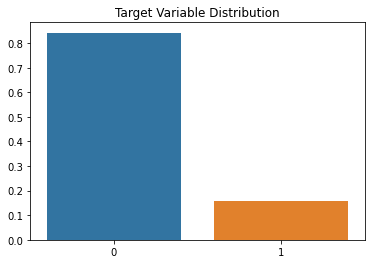

In [28]:
dis_label = data['EVENT_CRF'].value_counts(normalize=True)
sns.barplot(x=dis_label.index, y=dis_label.values)
plt.title('Target Variable Distribution')
plt.show()

**The target variable is unbalanced**

### Train Validation Test split

In [29]:
train, test = train_test_split(data, test_size=0.2, shuffle=True, stratify=data['EVENT_CRF'], random_state=0)

In [30]:
print('Train size:', train.shape[0])
print('Test size:', test.shape[0])

Train size: 47419
Test size: 11855


In [31]:
train_target = train['EVENT_CRF'].value_counts(normalize=True)
test_target = test['EVENT_CRF'].value_counts(normalize=True)

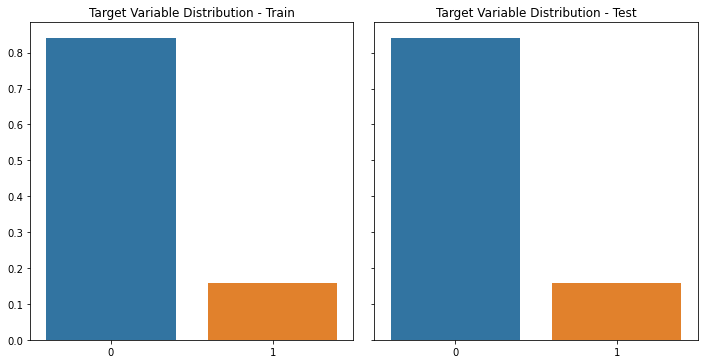

In [32]:
f, ax = plt.subplots(1,2, sharey=True, figsize=(10,5))
f.tight_layout(w_pad=0.5)

sns.barplot(x=train_target.index, y=train_target.values, ax = ax[0])
ax[0].set_title('Target Variable Distribution - Train')

sns.barplot(x=test_target.index, y=test_target.values, ax = ax[1])
ax[1].set_title('Target Variable Distribution - Test')

plt.show()


Let's see if there is a big difference in the target variable between women and men

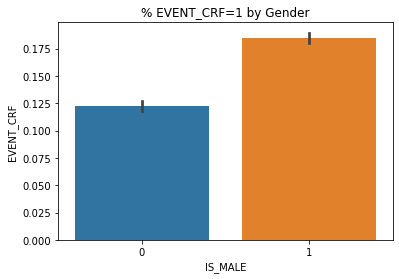

In [61]:
sns.barplot(x='IS_MALE', y='EVENT_CRF', data=train, ci=95)
plt.title('% EVENT_CRF=1 by Gender')
plt.show()

**It can be clearly seen that the percentage of positives in the men's group is greater than the percentage of positives in the women's group - with confidence of 95% and even more.**

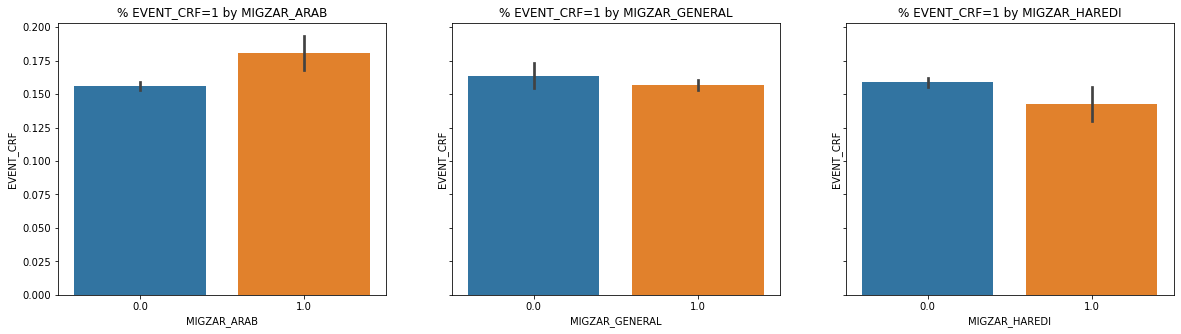

In [92]:
f, ax = plt.subplots(1,3, figsize=(20,5), sharey=True)
sns.barplot(x='MIGZAR_ARAB', y='EVENT_CRF', data=train, ci=95, ax=ax[0])
ax[0].set_title('% EVENT_CRF=1 by MIGZAR_ARAB')

sns.barplot(x='MIGZAR_GENERAL', y='EVENT_CRF', data=train, ci=95, ax=ax[1])
ax[1].set_title('% EVENT_CRF=1 by MIGZAR_GENERAL')

sns.barplot(x='MIGZAR_HAREDI', y='EVENT_CRF', data=train, ci=95, ax=ax[2])
ax[2].set_title('% EVENT_CRF=1 by MIGZAR_HAREDI')

plt.show()

1. With a confidence of 95% we can say the **Arab population has more positives**.
2. With 95% confidence we can say that the % positives in MIGZAR_GENERAL **is not different** from the others.
3. With 95% confidence we can say that the % positives in MIGZAR_HAREDI **is not different** from the others.

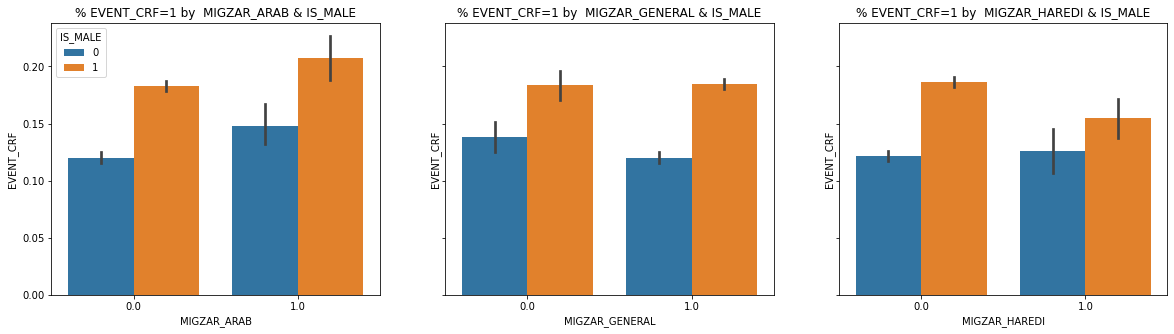

In [94]:
f, ax = plt.subplots(1,3, figsize=(20,5), sharey=True)
sns.barplot(x='MIGZAR_ARAB', y='EVENT_CRF',hue='IS_MALE', data=train, ci=95, ax=ax[0])
ax[0].set_title('% EVENT_CRF=1 by  MIGZAR_ARAB & IS_MALE')

sns.barplot(x='MIGZAR_GENERAL', y='EVENT_CRF',hue='IS_MALE', data=train, ci=95, ax=ax[1])
ax[1].set_title('% EVENT_CRF=1 by  MIGZAR_GENERAL & IS_MALE')
ax[1].get_legend().remove()

sns.barplot(x='MIGZAR_HAREDI', y='EVENT_CRF',hue='IS_MALE', data=train, ci=95, ax=ax[2])
ax[2].set_title('% EVENT_CRF=1 by  MIGZAR_HAREDI & IS_MALE')
ax[2].get_legend().remove()

plt.show()

1. With a confidence of 95% we can say that **the percentage of positive women in the Arab sector is higher than the percentage of positive women in the other sectors**.
2. With a confidence of 95% we can say that **the percentage of positive men in the Arab sector is not different from the men in the other sectors.**
3. With a confidence of 95% we can say that **the percentage of positive Arab men is greater than the percentage of positive Arab women**.
4. With a confidence of 95% we can say that **the percentage of positive men in the General sector is not different from the men in the other sectors.**
5. With a confidence of 95% we can say that **the percentage of positive men in the MIGZAR_HAREDI  is lower than the percentage of positive men in the other sectors**.

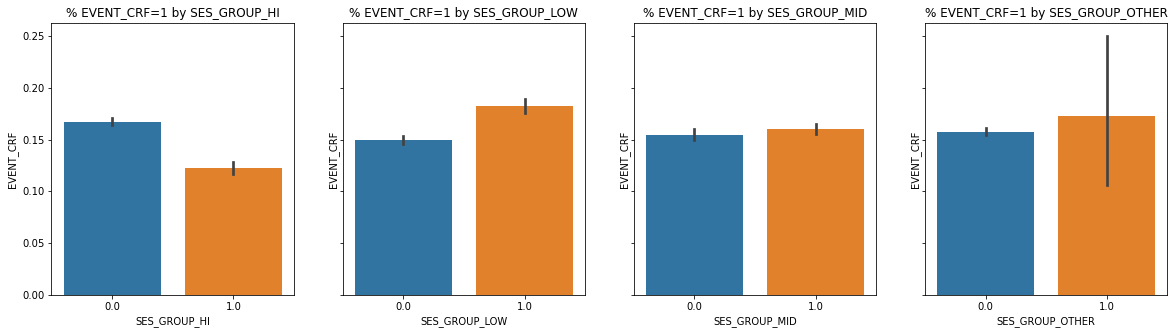

In [97]:
f, ax = plt.subplots(1,4, figsize=(20,5), sharey=True)
sns.barplot(x='SES_GROUP_HI', y='EVENT_CRF', data=train, ci=95, ax=ax[0])
ax[0].set_title('% EVENT_CRF=1 by SES_GROUP_HI')

sns.barplot(x='SES_GROUP_LOW', y='EVENT_CRF', data=train, ci=95, ax=ax[1])
ax[1].set_title('% EVENT_CRF=1 by SES_GROUP_LOW')

sns.barplot(x='SES_GROUP_MID', y='EVENT_CRF', data=train, ci=95, ax=ax[2])
ax[2].set_title('% EVENT_CRF=1 by SES_GROUP_MID')

sns.barplot(x='SES_GROUP_OTHER', y='EVENT_CRF', data=train, ci=95, ax=ax[3])
ax[3].set_title('% EVENT_CRF=1 by SES_GROUP_OTHER')

plt.show()

1. With a confidence of 95% we can say that **the percentage of positives in SES_GROUP_HI is lower than the percentage of positives in the other groups.**
2. With a confidence of 95% we can say that **the percentage of positives in SES_GROUP_LOW is higher than the percentage of positives in the other groups.**

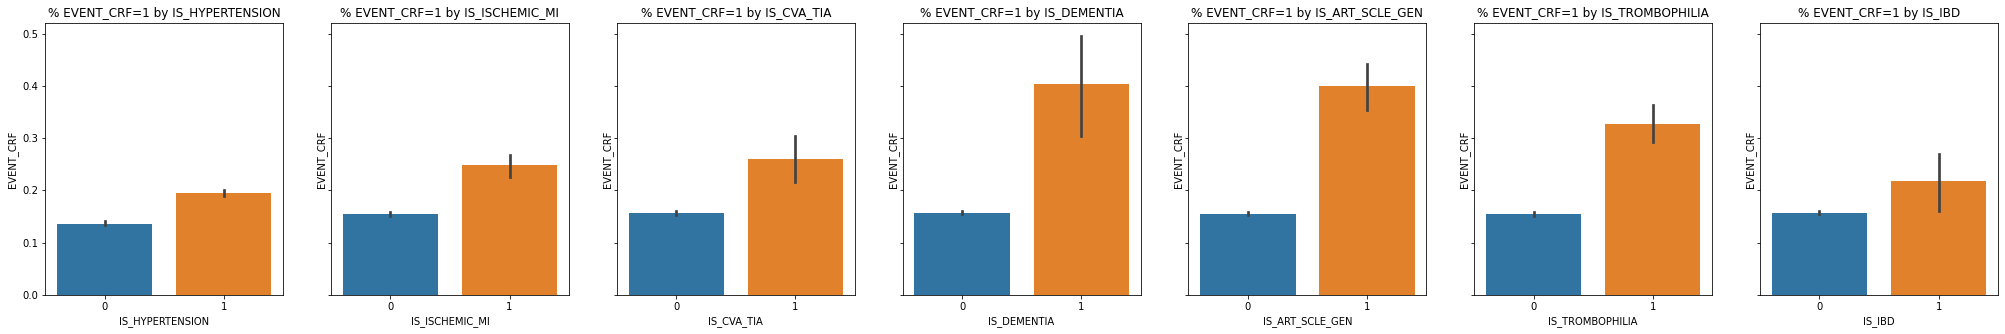

In [103]:
is_columns = [c for c in train.columns if 'IS_' in c and 'MALE' not in c]
f, ax = plt.subplots(1,len(is_columns), figsize=(35,5), sharey=True)
for i in range(len(is_columns)):
    sns.barplot(x=is_columns[i], y='EVENT_CRF', data=train, ci=95, ax=ax[i])
    ax[i].set_title(f'% EVENT_CRF=1 by {is_columns[i]}')


plt.show()


In general, a value of 1 in the IS_ * columns increases the chance of developing kidney disease.<br>
The most influential background diseases seem to be: IS_DEMENTIA, IS_ART_SCLE_GEN, IS_TROMBOPHILIA.

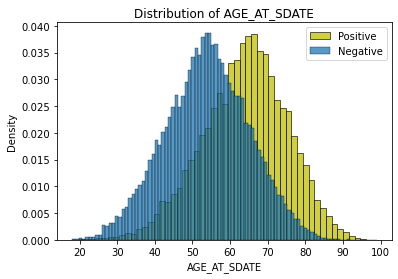

In [130]:
sns.histplot(x="AGE_AT_SDATE", data=train.loc[train['EVENT_CRF'] == 1], stat='density', color='y', label='Positive')
sns.histplot(x="AGE_AT_SDATE", data=train.loc[train['EVENT_CRF'] == 0], stat='density', label='Negative')
plt.title('Distribution of AGE_AT_SDATE')
plt.legend()
plt.show()

The age of onset of diabetes in people who have developed kidney disease appears to be later. Did they really get diabetes at a later age or were they diabetic and found out about it late?

### Benchmark

In order to check if our data provide added value and if possible build an effective model that will give significant predictions we will want to set a benchmark and then build a very simple model that will give you a sign if we are in the right direction.

Because our mission is a mission that deals with human life and can save lives the recall is terribly important to us. So we decided that our benchmark would be to predict for everyone 1.

**The benchmark predictions:**

In [90]:
train_benchmark, test_benchmark = train_test_split(train, test_size=0.2, shuffle=True, stratify=train['EVENT_CRF'])

In [91]:
y_pred_bechmark = np.ones_like(test_benchmark)

In [92]:
assert y_pred_bechmark.shape[0] ==  y_pred_bechmark.shape[0]

**Building a basemodel**

In [93]:
y_train_benchmark = train_benchmark['EVENT_CRF']
X_train_benchmark = train_benchmark.drop(['EVENT_CRF', 'TIME_CRF', 'IDS'], axis=1)

In [94]:
sampler = RandomOverSampler()
X_train_new, y_train_new = sampler.fit_resample(X_train_benchmark, y_train_benchmark)

In [95]:
y_test_benchmark = test_benchmark['EVENT_CRF']
X_test_benchmark = test_benchmark.drop(['EVENT_CRF', 'TIME_CRF', 'IDS'], axis=1)

We have decided that at this point only use columns that do not have missing values.

In [96]:
no_na = train.isnull().sum() == 0
no_na = no_na[no_na]

In [97]:
col_to_keep = list(no_na.index)
col_to_keep = [c for c in col_to_keep if c in list(X_train_benchmark.columns)]

In [98]:
X_train_new = X_train_new[col_to_keep]
X_test_benchmark = X_test_benchmark[col_to_keep]

In [99]:
fpr, tpr, thresholds =  roc_curve(y_test_benchmark, np.ones(y_test_benchmark.shape[0]) , pos_label=1)
roc_auc =  auc(fpr, tpr)

In [100]:
lg = LogisticRegression(solver='liblinear')
lg.fit(X_train_new, y_train_new)
y_pred = lg.predict(X_test_benchmark)

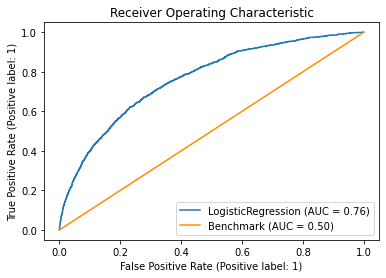

In [101]:
plot_roc_curve(lg, X_test_benchmark, y_test_benchmark)
plt.plot(fpr, tpr, color='darkorange', label='Benchmark (AUC = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.title('Receiver Operating Characteristic')
plt.show()

In [105]:
round(f1_score(y_test_benchmark, y_pred),3)

0.419

**Our basemodel indeed got higher AUC than the benchmark, so we want to continue to build a better and more complex model.**

### Missing Values

In [43]:
na = train.isna().sum()

In [44]:
na[na > 0]

SE_HYPERTENSION                   30342
SE_ISCHEMIC_MI                    45774
SE_CVA_TIA                        47064
SE_DEMENTIA                       47322
SE_ART_SCLE_GEN                   46980
SE_TROMBOPHILIA                   46695
SE_IBD                            47208
BMI_AT_BASELINE                   26509
SYSTOLA_AT_BASELINE               11182
DIASTOLA_AT_BASELINE              11182
Creatinine_B_AT_BASELINE           6832
Albumin_B_AT_BASELINE             20745
Urea_B_AT_BASELINE                 8503
Glucose_B_AT_BASELINE              5493
HbA1C_AT_BASELINE                  9226
RBCRed_Blood_Cells_AT_BASELINE     7966
Hemoglobin_AT_BASELINE             8001
Ferritin_AT_BASELINE              40014
AST_GOT_AT_BASELINE               14198
ALT_GPT_AT_BASELINE                8516
Bilirubin_Total_AT_BASELINE       23811
Na_Sodium_B_AT_BASELINE           11376
K_Potassium_B_AT_BASELINE         10764
CaCalcium_B_AT_BASELINE           19946
HDLCholesterol_AT_BASELINE         6253


As we can see there are a lot of missing values. <br>
We are going to split the missing values into two groups:
1. Missing values of tests
2. Missing values of SE_* columns

##### Test columns

The columns of the tests contain data on the various tests performed by diabetics.<br>We can see that there are relatively many missing values in the columns of the tests. And the question arises, are the missing values random? Or there is a reason why certain observations have missing values.<br>   

In [45]:
test_columns = ['BMI_AT_BASELINE', 'SYSTOLA_AT_BASELINE',
       'DIASTOLA_AT_BASELINE', 'Creatinine_B_AT_BASELINE',
       'Albumin_B_AT_BASELINE', 'Urea_B_AT_BASELINE', 'Glucose_B_AT_BASELINE',
       'HbA1C_AT_BASELINE', 'RBCRed_Blood_Cells_AT_BASELINE',
       'Hemoglobin_AT_BASELINE', 'Ferritin_AT_BASELINE', 'AST_GOT_AT_BASELINE',
       'ALT_GPT_AT_BASELINE', 'Bilirubin_Total_AT_BASELINE',
       'Na_Sodium_B_AT_BASELINE', 'K_Potassium_B_AT_BASELINE',
       'CaCalcium_B_AT_BASELINE', 'HDLCholesterol_AT_BASELINE',
       'LDLCholesterol_AT_BASELINE', 'Triglycerides_AT_BASELINE', 'PTH_AT_BASELINE']

In [46]:
pd.options.mode.chained_assignment = None  # default='warn'

# fixing the null values
train[test_columns] = train[test_columns].fillna(train[test_columns].mean())
test[test_columns]  = test[test_columns].fillna(train[test_columns].mean())

Confirm we do not have missing values

In [47]:
assert train[test_columns].isna().sum().sum() == 0
assert test[test_columns].isna().sum().sum() == 0

##### SE* columns

The columns of the SE* contain data on the time that has passed between a previous condition and contracting diabetes.<br>We can see that there are relatively many missing values -- presumably those who have not been listed to have that condition should have a null value<br>   

In [48]:
SE_columns = ['SE_HYPERTENSION',
'SE_ISCHEMIC_MI',
'SE_CVA_TIA',
'SE_DEMENTIA',
'SE_ART_SCLE_GEN',
'SE_TROMBOPHILIA',
'SE_IBD']

In [49]:
# fixing the null values
train[SE_columns] = train[SE_columns].fillna(0)
test[SE_columns]  = test[SE_columns].fillna(0)

In [50]:
assert train[SE_columns].isna().sum().sum() == 0
assert test[SE_columns].isna().sum().sum() == 0

# Unsupervised Learning

### Standard Scaler

In [80]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [81]:
train_unsupervised = train.drop(['TIME_CRF', 'EVENT_CRF', 'IDS'], axis=1)

In [82]:
scaler = StandardScaler()
train_unsupervised_array = scaler.fit_transform(train_unsupervised)

### Kmeans

In [ ]:
wscc = []
for k in range(2,200,5):
    kmeans = KMeans(k)
    kmeans.fit(train_unsupervised_array)
    wscc.append(kmeans.inertia_)

In [ ]:
sns.lineplot(x = range(2,200,5), y = wscc)
plt.title('WSCC As a Function of K')
plt.show()

In [ ]:
kmeans = KMeans(50, random_state=0, )
kmeans.fit(train_unsupervised_array)

In [ ]:
clusters = kmeans.predict(train_unsupervised_array)

In [ ]:
train_unsupervised['Cluster'] = clusters

In [ ]:
train_unsupervised['label'] = train['EVENT_CRF']

In [ ]:
sns.set(rc={'figure.figsize':(10,5)})


In [ ]:
print('Cluster Sizes\n', train_unsupervised['Cluster'].value_counts().sort_index())
sns.barplot(x = train_unsupervised['Cluster'], y = train_unsupervised['label'])
plt.title('% Positive In Each Cluster')
plt.xticks(rotation=90)
plt.show()

In [ ]:
train_unsupervised.groupby('Cluster')['label'].mean().sort_values(ascending=False).head(10)

### PCA

In [ ]:
pca = PCA(2)
two_dim = pca.fit_transform(train_unsupervised_array)

In [ ]:
sns.scatterplot(x=two_dim[:,0], y=two_dim[:,1], hue=train_unsupervised['label'])
plt.title('Project The Data in 2 Dimensions')
plt.show()

# Supervised Learning

### Model Selection

In [51]:
X_train = train.drop(['IDS', 'TIME_CRF', 'EVENT_CRF'], axis=1)
y_train = train['EVENT_CRF']

In [52]:
rf_clf = RandomForestClassifier()
ada_clf = AdaBoostClassifier()
log_clf = LogisticRegression(solver='liblinear')
svm_clf = svm.SVC() 
knn_clf = KNeighborsClassifier()

In [53]:
params_dict_ada = [{'n_estimators': [100, 150, 200, 250, 300, 500, 600, 800, 1000, 1200, 1400] , 
               'algorithm': ['SAMME', 'SAMME.R'],
               'learning_rate':[0.8, 0.9, 1, 1.05, 1.1, 1.2, 1.3, 1.4, 1.5]}]

params_dict_rf = [{'n_estimators': [100, 300, 600, 1000] , 
               'max_depth': [2, 4, 6 , 10, 15, 20, 30, 35],
               'min_samples_split': [50, 60, 100, 120, 200, 300 , 400, 500]}]

params_dict_log = [{'max_iter': [50, 100, 150, 300] , 
               'fit_intercept': [True, False]}]

params_dict_svm = [{'degree': [1, 2, 3, 4], 
               'C': [0.85, 0.95, 1, 1.05, 1.1]}]

params_dict_knn = [{'n_neighbors': [3, 5, 10, 15, 20, 30, 40, 50, 100, 200, 500]}]

In [58]:
models = [ada_clf] #, rf_clf, log_clf, svm_clf, knn_clf]
params = [params_dict_ada, params_dict_rf, params_dict_log, params_dict_svm, params_dict_knn]
how_many_iter = [25, 15, 2, 10, 8]

In [59]:
results = {}
for i in range(len(models)):
    random_search = RandomizedSearchCV(models[i], 
                                      params[i], 
                                      cv = 3, 
                                      scoring='f1',
                                      verbose=2,
                                      n_jobs=-1,
                                      n_iter=how_many_iter[i])
    random_search.fit(X_train, y_train)
    results[str(models[i])] = random_search

Fitting 3 folds for each of 25 candidates, totalling 75 fits


In [60]:
results_df = pd.DataFrame(columns=['Model', 'Best F1 Score'])
for m in results:
    results_df = results_df.append({'Model': str(results[m].best_estimator_),
                                    'Best F1 Score': results[m].best_score_}, ignore_index=True)
results_df = results_df.sort_values('Best F1 Score', ascending=False)

In [65]:
results_df['Model'][0]

'AdaBoostClassifier(learning_rate=1.2, n_estimators=500)'

[CV] END algorithm=SAMME, learning_rate=1.4, n_estimators=250; total time=  10.7s
[CV] END algorithm=SAMME, learning_rate=1.2, n_estimators=1400; total time= 1.1min
[CV] END algorithm=SAMME.R, learning_rate=1.2, n_estimators=500; total time=  26.7s
[CV] END algorithm=SAMME.R, learning_rate=1.2, n_estimators=800; total time=  41.5s
[CV] END algorithm=SAMME.R, learning_rate=0.8, n_estimators=600; total time=  31.8s
[CV] END algorithm=SAMME.R, learning_rate=1, n_estimators=800; total time=  41.9s
[CV] END algorithm=SAMME, learning_rate=1.1, n_estimators=200; total time=  10.1s
[CV] END algorithm=SAMME, learning_rate=0.9, n_estimators=800; total time=  39.2s
[CV] END algorithm=SAMME, learning_rate=1.3, n_estimators=300; total time=  14.7s
[CV] END algorithm=SAMME.R, learning_rate=1.5, n_estimators=200; total time=  10.6s
[CV] END algorithm=SAMME, learning_rate=1.4, n_estimators=250; total time=  10.7s
[CV] END algorithm=SAMME.R, learning_rate=1.1, n_estimators=250; total time=  11.4s
[CV] 

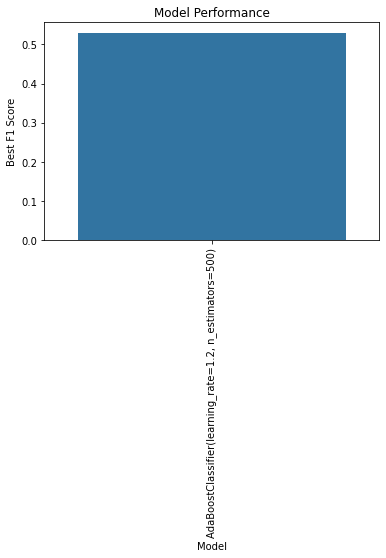

In [62]:
sns.barplot(x = results_df['Model'], y = results_df['Best F1 Score'])
plt.xticks(rotation=90)
plt.title('Model Performance')
plt.show()

In [63]:
best_model = results[results_df.iloc[0,0].split('(')[0] + '()'].best_estimator_

In [ ]:
second_model = results[results_df.iloc[1,0].split('(')[0] + '()'].best_estimator_

### Test

In [ ]:
X_test = test.drop(['IDS', 'TIME_CRF', 'EVENT_CRF'], axis=1)
y_test = test['EVENT_CRF']

In [ ]:
pred_test = best_model.predict(X_test)

In [ ]:
f1_score_test = round(f1_score(y_test, pred_test),3)

In [ ]:
print('Performance on the test (F1):', f1_score_test)

In [ ]:
plot_roc_curve(best_model, X_test, y_test)
plt.show()

**The AUC increased from 0.76 to 0.83**

### Interpretability 

In [ ]:
feature_importace_ada =  pd.DataFrame({'Feature': X_train.columns, 'Importace':best_model.feature_importances_}).sort_values('Importace', ascending=False)

In [ ]:
feature_importace_rf =  pd.DataFrame({'Feature': X_train.columns, 'Importace':second_model.feature_importances_}).sort_values('Importace', ascending=False)

In [ ]:
sns.barplot(x = feature_importace_ada.Feature, y = feature_importace_ada.Importace)
plt.xticks(rotation=90)
plt.title('Feature Importance - AdaBoost')
plt.show()

In [ ]:
sns.barplot(x = feature_importace_rf.Feature, y = feature_importace_rf.Importace)
plt.xticks(rotation=90)
plt.title('Feature Importance - Random Forest')
plt.show()